## Imports

In [ ]:
!pip install chess
!pip install datasets
!pip install zstandard

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch

import chess
import chess.engine
import chess.svg

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

from transformers import AutoTokenizer, TextGenerationPipeline, \
    GPT2LMHeadModel, GPT2Tokenizer, pipeline

from datasets import load_from_disk  # load_dataset

from copy import deepcopy
from typing import List, Dict, Optional, Any

from drive.MyDrive.data.chessplaying_utils import *


import warnings
warnings.filterwarnings("ignore")

In [6]:
!chmod +x /content/drive/MyDrive/data/stockfish-ubuntu-x86-64-avx2

In [7]:
moves_data = "/content/drive/MyDrive/data/subset_games"
stockfish_path = (
    "/content/drive/MyDrive/data/stockfish-ubuntu-x86-64-avx2"
)
stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [8]:
WHITE = 0
BLACK = 1

## Data

In [ ]:
# dataset = load_dataset("mlabonne/chessllm")

In [ ]:
# subset = dataset["train"].select(range(1000))
# subset.save_to_disk("data/subset_games")

In [9]:
test_data_moves = load_from_disk(moves_data)
test_data_moves

Dataset({
    features: ['average_elo', 'transcript'],
    num_rows: 1000
})

In [10]:
test_data_moves['transcript'][:5]

['1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1',
 '1. e4 c5 2. Nf3 e6 3. d4 d5 4. exd5 exd5 5. Ne5 a6 6. Qh5 Nf6 7. Qxf7# 1-0',
 '1. d4 d5 2. Nc3 Bd7 3. e4 dxe4 4. Nxe4 Nc6 5. c3 a6 6. Qf3 g6 7. Bd3 Bg7 8. Ne2 Nf6 9. O-O Bg4 10. Nxf6+ Bxf6 11. Qxg4 O-O 12. Bh6 e5 13. Bxf8 Kxf8 14. Rad1 exd4 15. Nxd4 Nxd4 16. Bxg6 hxg6 17. cxd4 Kg7 18. f4 Qd6 19. f5 Rh8 20. g3 Qb6 21. fxg6 Qxb2 22. gxf7+ Kxf7 23. Qd7+ Kg6 24. Rxf6+ Kxf6 25. Rf1+ Kg6 26. Qf7+ Kh6 27. Rf6+ 1-0',
 '1. e4 Nc6 2. d3 Nd4 3. Nd2 Ne6 4. Ngf3 Nf4 5. g3 Ng6 6. Bg2 Nf6 7. O-O d6 8. Rfe1 Qd7 9. Nf1 Qg4 10. d4 Nxe4 11. Nf3d2 Qxd1 12. Rexd1 Ng5 13. Ne4 Ne6 14. Ng5 Nd8 15. Rde1 Bf5 16. Ne3 Bd7 17. a4 Bc6 18. b4 e6 19. b5 Bd7 20. c4 Be7 21. a5 Bxg5 22. a6 bxa6 23

## Model loading

In [11]:
device_name = torch.cuda.get_device_name(0)
print("Device 0:", device_name)

Device 0: Tesla T4


In [ ]:
MIN_TRANSFORMERS_VERSION = '4.25.1'

# check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

# init
tokenizer = AutoTokenizer.from_pretrained("Waterhorse/chessgpt-base-v1")
model = AutoModelForCausalLM.from_pretrained("Waterhorse/chessgpt-base-v1", torch_dtype=torch.float16)
model = model.to('cuda:0')


In [13]:
generator = pipeline("text-generation",
                     model=model,
                     tokenizer=tokenizer,
                     device=0,
                     )

In [14]:
test_data_moves[0]

{'average_elo': 1500.0,
 'transcript': '1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1'}

In [15]:
generator.model.config.do_sample = True

In [16]:
generate_next_moves(test_data_moves[0]['transcript'][:20], generator, tokenizer, num_answers = 2)

['dxe5 Qe7 4. exd5 Qxe5+ 5. Qe2', 'dxe5 d4 4. Bf4 g5 5. Bg3 h5 6']

In [17]:
model_config = generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups}
{model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size}
{model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1)
True
(1.0, 50)
(20, 0)
False
1



In [18]:
generate_answer(generator, "Once upon a time,", num_answers=2)

["Once upon a time, we all enjoyed playing online Chess960 because it was fun and exciting.\nWhat's the point of changing a game that is good if it's going to be modified to",
 'Once upon a time, there was a queen who didn’t want to lose her power. That is how she invented chess. She could have also invented it as a game that is based on kings']

## Evaluation based on previous moves

#### Test 1: for a single situation analyse gpt answers

Using sampling to get multiple answers to a prompt.

Game 0 | Number of moves: 5 | Evaluated answers: 20


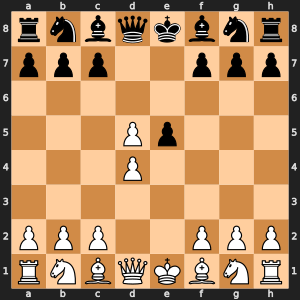

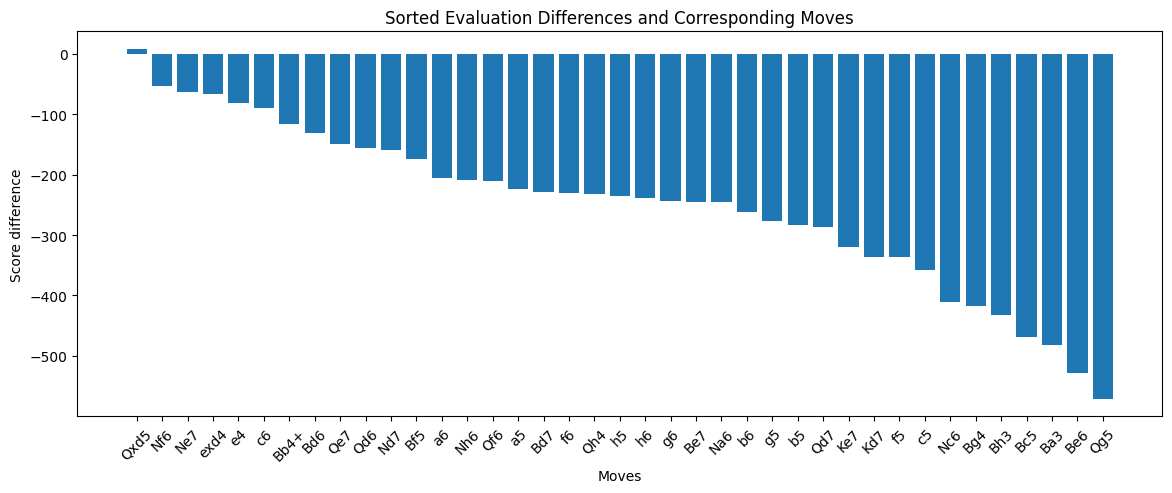

Worst move: Qg5 score difference: -571
Best move: Qxd5 score difference: 8
Mean difference score: -250.12820512820514
-----------------------------------------------------------------------------------
GPT-2 results:
  - Legal moves made: 20 / 20
  - Number of times the worst move was made: 0
  - Number of times the best move was made: 12
  - Number of times an above average move was made: 20


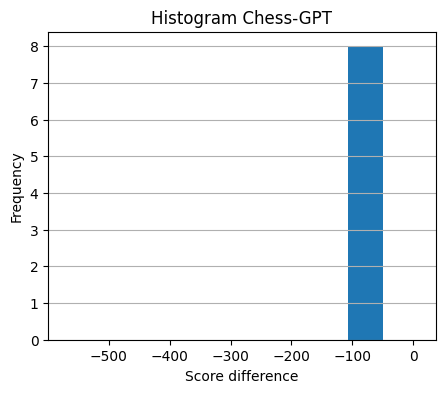

-----------------------------------------------------------------------------------
Random results:
  - Number of times the worst move was made: 0
  - Number of times the best move was made: 1
  - Number of times an above average move was made: 9


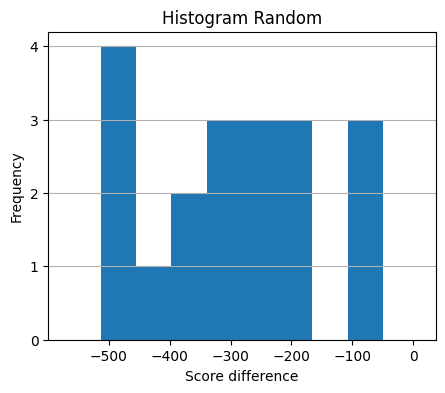

-----------------------------------------------------------------------------------
Player move score difference: -81
Game 1 | Number of moves: 5 | Evaluated answers: 20


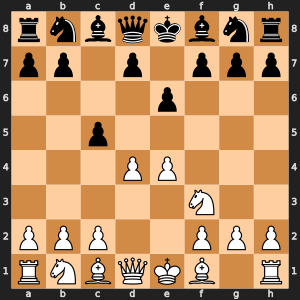

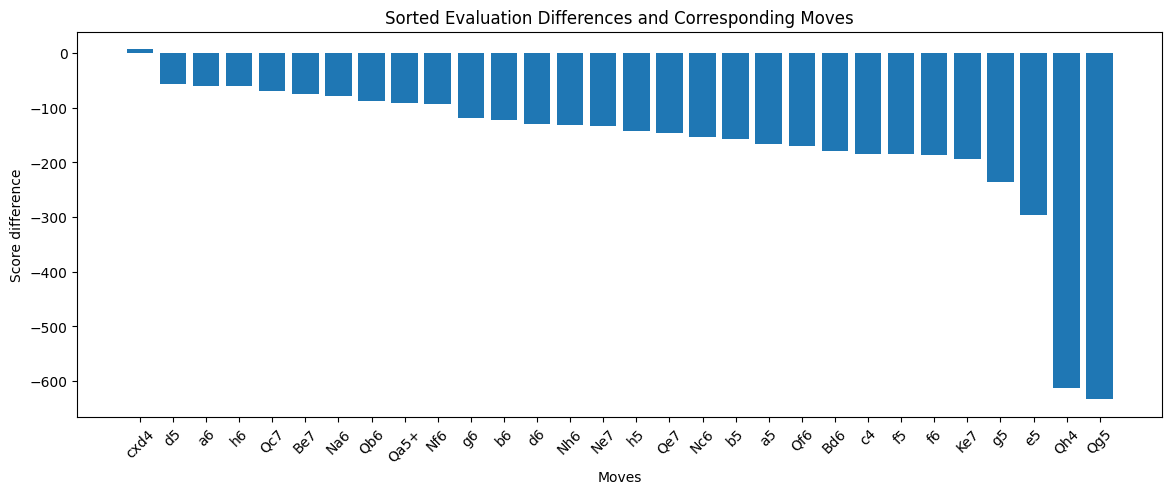

Worst move: Qg5 score difference: -633
Best move: cxd4 score difference: 7
Mean difference score: -164.93333333333334
-----------------------------------------------------------------------------------
GPT-2 results:
  - Legal moves made: 20 / 20
  - Number of times the worst move was made: 0
  - Number of times the best move was made: 19
  - Number of times an above average move was made: 20


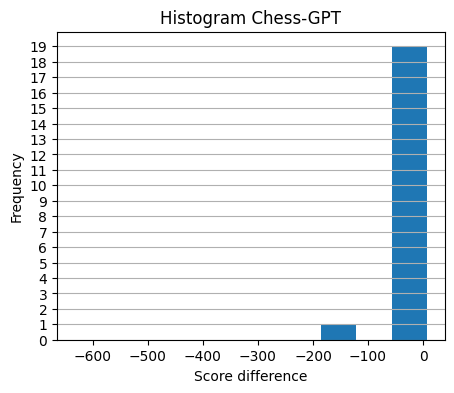

-----------------------------------------------------------------------------------
Random results:
  - Number of times the worst move was made: 0
  - Number of times the best move was made: 1
  - Number of times an above average move was made: 13


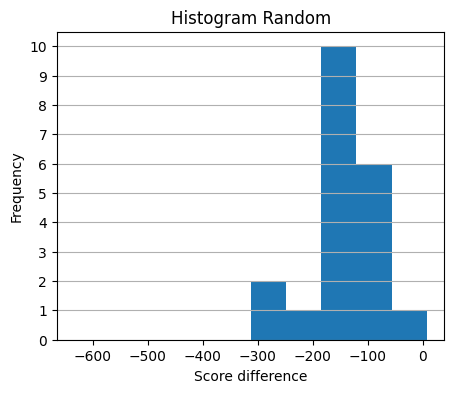

-----------------------------------------------------------------------------------
Player move score difference: -52


In [22]:
num_games = 2
transcripts = test_data_moves["transcript"][:num_games]
summary_gpt, summary_random, summary_player = \
    run_single_game_eval(transcripts, 5, 20, stockfish, generator, tokenizer,
                         print_conclusions=True, show_plots=True)

In [20]:
num_games = 20
transcripts = test_data_moves["transcript"][:num_games]

num_answers = 20
tests_num_moves: List[int] = [5, 10, 15, 20]

player_dict: Dict[str, Any] = {"gpt": None, "random": None, "player": None}
summaries: Dict[int, Dict[str, Any]] = \
    dict((x, deepcopy(player_dict)) for x in tests_num_moves)
player_avg_diff_scores: List[float] = []

for num_moves in tests_num_moves:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Testing results after {num_moves} moves")
    summary_gpt, summary_random, summary_player = \
        run_single_game_eval(transcripts, num_moves, num_answers,
                             stockfish, generator, tokenizer)
    summaries[num_moves]["gpt"] = summary_gpt
    summaries[num_moves]["random"] = summary_random
    summaries[num_moves]["player"] = summary_player

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 5 moves


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 10 moves
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 15 moves
15 is too many moves for game 1, skipping...
15 is too many moves for game 5, skipping...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 20 moves
20 is too many moves for game 1, skipping...
20 is too many moves for game 5, skipping...


Number of moves before evaluation: 5
---------------------------------------
GPT-2:
 - Average score difference after move: -28.354342105263157
 - Total number of legal moves: 392 / 400
 - Total number of best moves: 161 / {summaries[num_moves]["gpt"]["total_legal_moves"]}
 - Total number of worst moves: 2 / 392
 - Total number of above average moves: 382 / 392


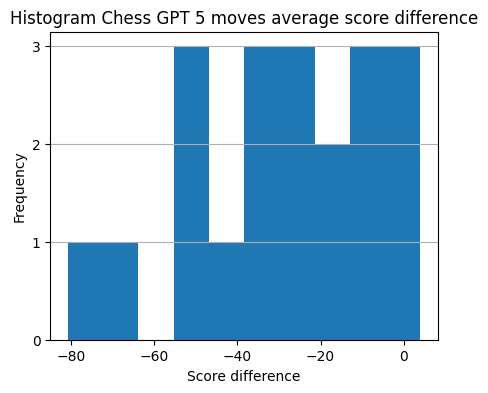

---------------------------------------
Random:
 - Average score difference after move: -138.06355263157894
 - Total number of best moves: 9 / 392
 - Total number of worst moves: 12 / 392
 - Total number of above average moves: 284 / 392


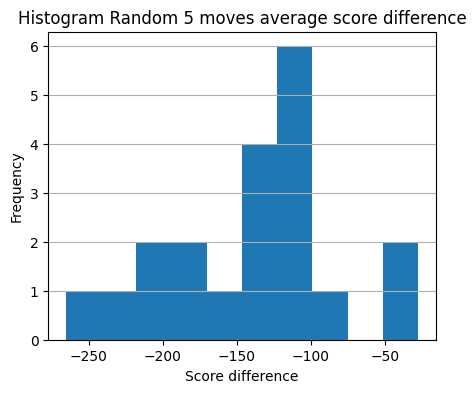

---------------------------------------
Player:
 - Average score difference after move: -26.85
 - Total number of best moves: 7 / 20
 - Total number of worst moves: 0 / 20
 - Total number of above average moves: 20 / 20
Number of moves before evaluation: 10
---------------------------------------
GPT-2:
 - Average score difference after move: -47.69894736842106
 - Total number of legal moves: 398 / 400
 - Total number of best moves: 107 / {summaries[num_moves]["gpt"]["total_legal_moves"]}
 - Total number of worst moves: 0 / 398
 - Total number of above average moves: 390 / 398


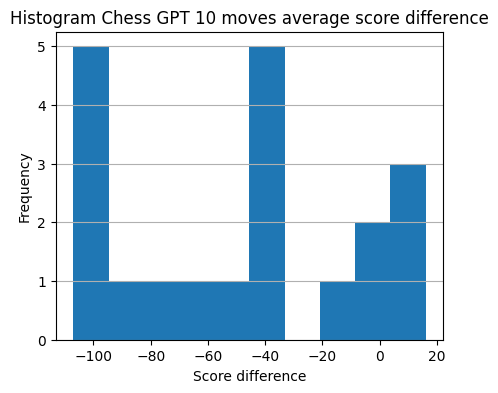

---------------------------------------
Random:
 - Average score difference after move: -249.0065789473684
 - Total number of best moves: 12 / 398
 - Total number of worst moves: 13 / 398
 - Total number of above average moves: 251 / 398


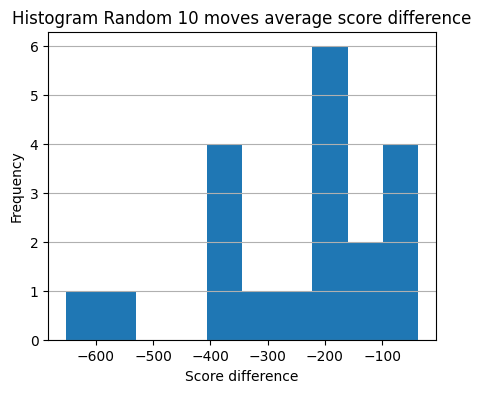

---------------------------------------
Player:
 - Average score difference after move: -76.0
 - Total number of best moves: 4 / 20
 - Total number of worst moves: 0 / 20
 - Total number of above average moves: 19 / 20
Number of moves before evaluation: 15
---------------------------------------
GPT-2:
 - Average score difference after move: -102.12125998547566
 - Total number of legal moves: 355 / 360
 - Total number of best moves: 112 / {summaries[num_moves]["gpt"]["total_legal_moves"]}
 - Total number of worst moves: 0 / 355
 - Total number of above average moves: 328 / 355


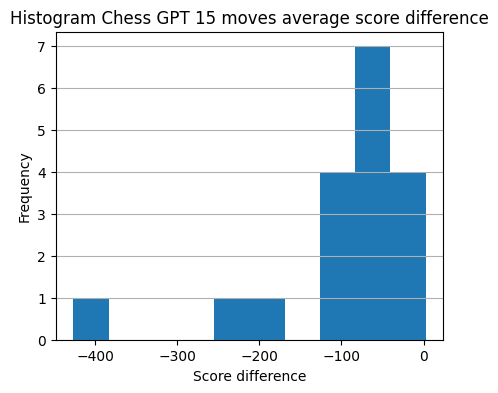

---------------------------------------
Random:
 - Average score difference after move: -277.781281771968
 - Total number of best moves: 10 / 355
 - Total number of worst moves: 8 / 355
 - Total number of above average moves: 198 / 355


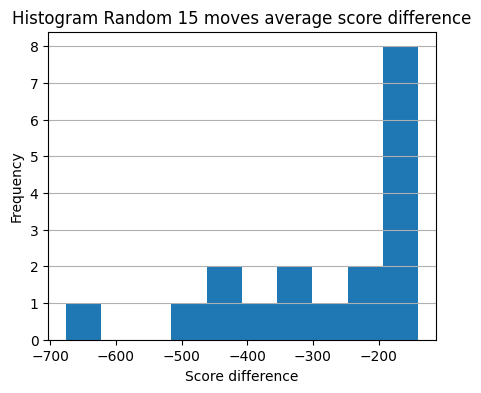

---------------------------------------
Player:
 - Average score difference after move: -89.66666666666667
 - Total number of best moves: 8 / 18
 - Total number of worst moves: 0 / 18
 - Total number of above average moves: 16 / 18
Number of moves before evaluation: 20
---------------------------------------
GPT-2:
 - Average score difference after move: -101.49738562091504
 - Total number of legal moves: 357 / 360
 - Total number of best moves: 96 / {summaries[num_moves]["gpt"]["total_legal_moves"]}
 - Total number of worst moves: 0 / 357
 - Total number of above average moves: 333 / 357


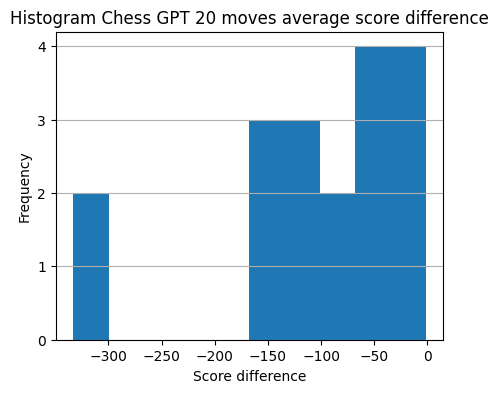

---------------------------------------
Random:
 - Average score difference after move: -358.7132352941177
 - Total number of best moves: 16 / 357
 - Total number of worst moves: 17 / 357
 - Total number of above average moves: 177 / 357


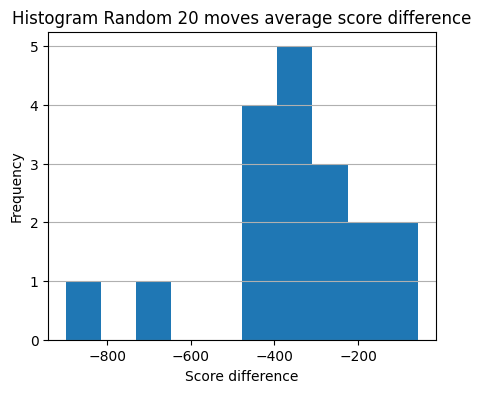

---------------------------------------
Player:
 - Average score difference after move: -90.0
 - Total number of best moves: 4 / 18
 - Total number of worst moves: 0 / 18
 - Total number of above average moves: 17 / 18

Aggregate results GPT-2
 - Average score difference after move: -69.91798377001874
 - Total number of legal moves: 1502 / 1520
 - Total number of best moves: 476 / 1502
 - Total number of worst moves: 2 / 1502
 - Total number of above average moves: 1433 / 1502
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -255.89116216125825
 - Total number of best moves: 47 / 1502
 - Total number of worst moves: 50 / 1502
 - Total number of above average moves: 910 / 1502
----------------------------------------------------------------
Aggregate results Player
 - Average score difference after move: -70.62916666666666
 - Total number of best moves: 23 / 76
 - Total number of worst moves: 0 / 76
 - Tota

In [21]:
show_results_single_eval(summaries, tests_num_moves)